# MNIST 데이터셋에 대한 Classification Model 로 구현

- 풀고자 하는 문제는, 흑백 손글씨 이미지를 보고, 이 손글씨가 0 ~ 9 중 어떤 숫자인지를 맞추는 문제입니다.
- 즉, 흑백 이미지를 0 ~ 9, 총 10개의 숫자로 분류를 해야합니다.
- 그래서 MNIST 데이터셋을 input 으로 받아서 10 개의 숫자 중 1개로 분류해주는 Classification Model 을 만들어 보겠습니다.  

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from matplotlib import pyplot as plt

In [2]:
DIR_ROOT_DATA = "../data"

MNIST_BATCH_SIZE = 256
MNIST_NUM_EPOCHS = 100
MNIST_LEARNING_RATE = 0.001

In [3]:
transform = transforms.ToTensor()

mnist_train_set = torchvision.datasets.MNIST(
    root=DIR_ROOT_DATA, train=True, download=True, transform=transform
)
mnist_train_loader = torch.utils.data.DataLoader(
    mnist_train_set,
    batch_size=MNIST_BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

mnist_test_set = torchvision.datasets.MNIST(
    root=DIR_ROOT_DATA, train=False, download=True, transform=transform
)
mnist_test_loader = torch.utils.data.DataLoader(
    mnist_test_set, batch_size=MNIST_BATCH_SIZE, shuffle=False
)

## MNIST 데이터셋
- 0 ~ 9 까지의 숫자에 대한 손글씨 이미지로, 흑백 이미지
- 다음은 데이터셋의 클래스이다.
    - 레이블 0: 숫자 0
    - 레이블 1: 숫자 1
    - 레이블 2: 숫자 2
    - 레이블 3: 숫자 3
    - 레이블 4: 숫자 4
    - 레이블 5: 숫자 5
    - 레이블 6: 숫자 6
    - 레이블 7: 숫자 7
    - 레이블 8: 숫자 8
    - 레이블 9: 숫자 9

mnist_images.shape: torch.Size([256, 1, 28, 28])
label: 7


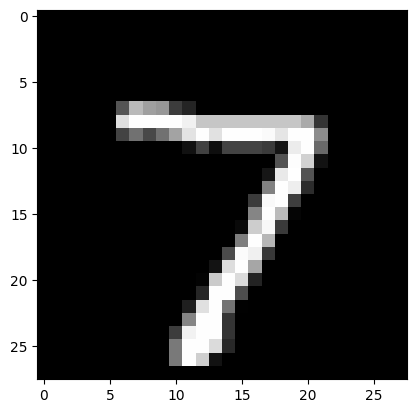

In [4]:
mnist_images, mnist_labels = next(iter(mnist_test_loader))
print("mnist_images.shape:", mnist_images.shape)

print("label:", mnist_labels[0].item())
plt.imshow(transforms.ToPILImage()(mnist_images[0]), cmap="gray")

In [5]:
def get_device() -> torch.device:
    """
    mps, cuda, cpu 순으로 사용 가능을 체크해서 반환
    :return: 사용 가능한 pytorch device
    """
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def calculate_accuracy(
    device: torch.device, model: nn.Module, data_loader: torch.utils.data.DataLoader
) -> float:
    """
    model 에 대한 평가를 진행하여, 예측의 정확도를 계산
    :return: 정확도
    """
    total = 0
    num_correctness = 0

    model.eval()
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            inputs, labels = images.to(device), labels.to(device)

            outputs = model(inputs)

            total += labels.size(0)

            predictions = torch.argmax(outputs, dim=1)
            num_correctness += (predictions == labels).sum().item()
    model.train()

    return num_correctness / total

In [6]:
class MNISTClassificationModel(nn.Module):
    def __init__(self):
        super(MNISTClassificationModel, self).__init__()

        input_dim = 1 * 28 * 28  # input dimension 은 이미지의 크기
        hidden_dim = 1024
        num_classes = 10  # output dimension 은 0 ~ 9 까지의 분류

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, num_classes)

        self.activation = nn.ReLU()

    def forward(self, x):
        # x.shape: (batch_size, 1, 28, 28)
        x = torch.flatten(x, start_dim=1)  # x.shape: (batch_size, 1* 28 * 28)
        x = self.activation(self.layer1(x))  # x.shape: (batch_size, hidden_dim)
        x = self.activation(self.layer2(x))  # x.shape: (batch_size, hidden_dim)
        x = self.layer3(x)  # x.shape: (batch_size, 10)
        return x

In [7]:
device = get_device()
device

device(type='mps')

In [8]:
mnist_model = MNISTClassificationModel().to(device)
mnist_model

MNISTClassificationModel(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=10, bias=True)
  (activation): ReLU()
)

## Cross Entropy Loss 함수
- Cross Entropy Loss (교차 엔트로피 손실)는 분류 문제에서 널리 사용되는 손실 함수
- 이 함수는 모델의 예측 확률 분포와 실제 레이블의 확률 분포 간의 차이를 측정

### 수식
$$L = -\sum_{i=1}^{C} y_i \log(p_i)$$
- $C$는 클래스의 수
- $y_i$는 실제 레이블 (원-핫 인코딩)
- $p_i$는 클래스 $i$에 대한 모델의 예측 확률

### MNIST 분류에서의 사용 이유
- 확률적 해석 
   - Cross Entropy Loss를 사용하면 모델의 출력을 확률로 해석할 수 있습니다.
   - MNIST에서 각 숫자(0-9)에 대한 예측 확률을 직접적으로 얻을 수 있습니다.

- 학습 효율성 
   - 오차가 클수록 더 큰 페널티를 부여합니다.
   - 이는 모델이 잘못된 예측에 대해 더 빠르게 학습하도록 유도합니다.

- 다중 클래스 적합성 
   - MNIST는 10개의 클래스(0-9)를 가진 다중 클래스 문제입니다.
   - Cross Entropy Loss는 다중 클래스 분류에 자연스럽게 적용됩니다.

- 미분 가능성 
   - 이 손실 함수는 연속적이고 미분 가능합니다.
   - 이는 역전파 알고리즘을 사용한 신경망 학습에 필수적입니다.


In [9]:
# '손실 함수'를 'criterion'이라고 부르는 것은 PyTorch 의 관행
# 단순히 '손실'을 넘어 '평가 기준'이라는 더 넓은 의미를 가짐
# 이는 모델의 성능을 평가하고 최적화하는 기준이 됨
mnist_criterion = nn.CrossEntropyLoss()
mnist_criterion

CrossEntropyLoss()

In [10]:
mnist_optimizer = optim.SGD(mnist_model.parameters(), lr=MNIST_LEARNING_RATE)
mnist_optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [11]:
mnist_accuracies = np.zeros((2, MNIST_NUM_EPOCHS))  # training_accuracy, test_accuracy

for epoch in range(MNIST_NUM_EPOCHS):
    for data in mnist_train_loader:
        mnist_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outputs = mnist_model(inputs)  # logits 이 출력됨.

        loss = mnist_criterion(
            outputs, labels
        )  # cross entropy 에는 나온 출력값(logits) 그대로 넣어준다.
        loss.backward()

        mnist_optimizer.step()

    mnist_accuracies[0][epoch] = calculate_accuracy(
        device, mnist_model, mnist_train_loader
    )
    mnist_accuracies[1][epoch] = calculate_accuracy(
        device, mnist_model, mnist_test_loader
    )

    print(f"Epoch {epoch + 1:3d}, Training Accuracy: {mnist_accuracies[0][epoch]:.5f}")

Epoch   1, Training Accuracy: 0.14957
Epoch   2, Training Accuracy: 0.31040
Epoch   3, Training Accuracy: 0.41590
Epoch   4, Training Accuracy: 0.47763
Epoch   5, Training Accuracy: 0.52135
Epoch   6, Training Accuracy: 0.55278
Epoch   7, Training Accuracy: 0.57805
Epoch   8, Training Accuracy: 0.59893
Epoch   9, Training Accuracy: 0.61808
Epoch  10, Training Accuracy: 0.63695
Epoch  11, Training Accuracy: 0.65408
Epoch  12, Training Accuracy: 0.67027
Epoch  13, Training Accuracy: 0.68408
Epoch  14, Training Accuracy: 0.69632
Epoch  15, Training Accuracy: 0.70587
Epoch  16, Training Accuracy: 0.71477
Epoch  17, Training Accuracy: 0.72277
Epoch  18, Training Accuracy: 0.73075
Epoch  19, Training Accuracy: 0.73937
Epoch  20, Training Accuracy: 0.74790
Epoch  21, Training Accuracy: 0.75725
Epoch  22, Training Accuracy: 0.76832
Epoch  23, Training Accuracy: 0.77813
Epoch  24, Training Accuracy: 0.78700
Epoch  25, Training Accuracy: 0.79450
Epoch  26, Training Accuracy: 0.80190
Epoch  27, T

### 각 Epoch 별 모델에 대한 Accuracy 그래프

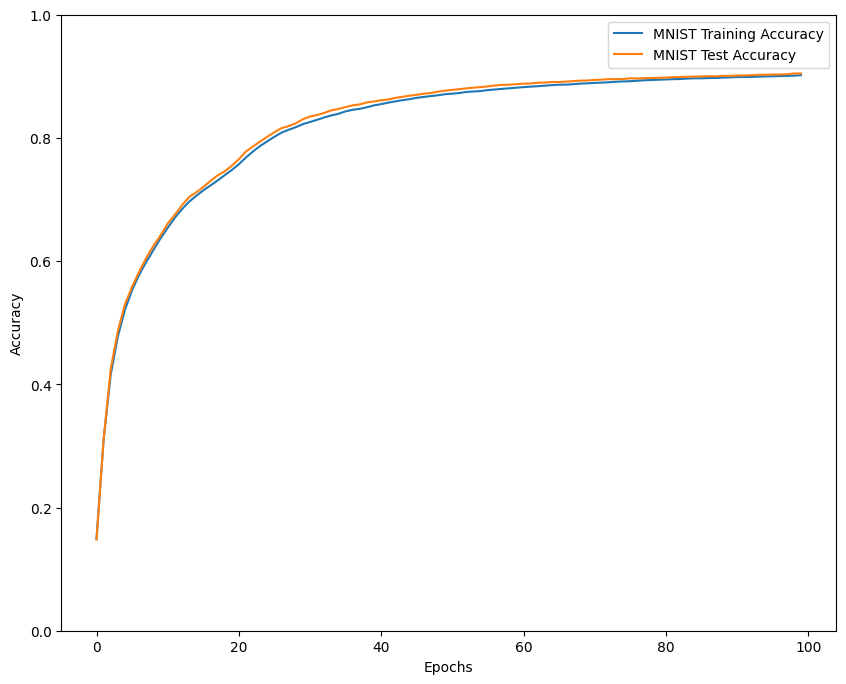

In [12]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(MNIST_NUM_EPOCHS)
plt.plot(x_axis, mnist_accuracies[0], label="MNIST Training Accuracy")
plt.plot(x_axis, mnist_accuracies[1], label="MNIST Test Accuracy")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

# CIFAR10 데이터셋에 대한 Classification Model 구현

- CIFAR-10 데이터셋은 10개의 클래스로 구성된 60,000개의 32x32 컬러 이미지입니다.
- 각 클래스당 6,000개의 이미지가 있습니다. 
- 50,000개의 훈련용 이미지와 10,000개의 테스트용 이미지로 구성되어 있습니다.
- 다음은 데이터셋의 클래스들입니다.
    - 레이블 0: 비행기
    - 레이블 1: 자동차
    - 레이블 2: 새
    - 레이블 3: 고양이
    - 레이블 4: 사슴
    - 레이블 5: 개
    - 레이블 6: 개구리
    - 레이블 7: 말
    - 레이블 8: 배
    - 레이블 9: 트럭
- [참고 링크](https://www.cs.toronto.edu/~kriz/cifar.html)

In [13]:
CIFAR_BATCH_SIZE = 256
CIFAR_NUM_EPOCHS = 50
CIFAR_LEARNING_RATE = 0.001

In [14]:
transform = transforms.ToTensor()

cifar_train_set = torchvision.datasets.CIFAR10(
    root=DIR_ROOT_DATA, train=True, download=True, transform=transform
)
cifar_train_loader = torch.utils.data.DataLoader(
    cifar_train_set,
    batch_size=CIFAR_BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

cifar_test_set = torchvision.datasets.CIFAR10(
    root=DIR_ROOT_DATA, train=False, download=True, transform=transform
)
cifar_test_loader = torch.utils.data.DataLoader(
    cifar_test_set, batch_size=CIFAR_BATCH_SIZE, shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


## 예시 이미지
- CIFAR 10 데이터셋 중 이미지 한 개를 확인해보겠습니다.

shape of cifar_images: torch.Size([256, 3, 32, 32])
label: 3 which is: 고양이


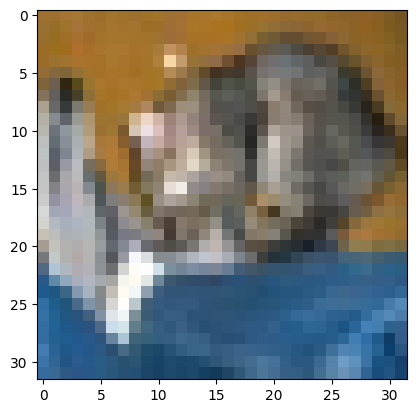

In [15]:
# 레이블에 해당하는 종류를 글자로 바꿀 수 있도록 tuple 을 준비
names = ("비행기", "자동차", "새", "고양이", "사슴", "개", "개구리", "말", "배", "트럭")

cifar_images, cifar_labels = next(iter(cifar_test_loader))

print("shape of cifar_images:", cifar_images.shape)

print("label:", cifar_labels[0].item(), "which is:", names[cifar_labels[0].item()])
plt.imshow(transforms.ToPILImage()(cifar_images[0]))

In [16]:
class SimpleImageClassificationModel(nn.Module):
    def __init__(self, num_channels, image_width, image_height, num_output_class):
        super(SimpleImageClassificationModel, self).__init__()
        hidden_dim = 1024

        input_dim = num_channels * image_width * image_height

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, num_output_class)

        self.activation = nn.LeakyReLU()

    def forward(self, x):
        # x.shape: (batch_size, channels, width, height)
        x = torch.flatten(
            x, start_dim=1
        )  # x.shape: (batch_size, channels * width * height)
        x = self.activation(self.layer1(x))  # x.shape: (batch_size, 2048)
        x = self.activation(self.layer2(x))  # x.shape: (batch_size, 2048)
        x = self.layer3(x)  # x.shape: (batch_size, num_output_classes)
        return x

In [17]:
cifar_model_for_sgd = SimpleImageClassificationModel(3, 32, 32, 10).to(device)
cifar_model_for_adam = SimpleImageClassificationModel(3, 32, 32, 10).to(device)

In [18]:
cifar_sdg_optimizer = optim.SGD(
    cifar_model_for_sgd.parameters(), lr=CIFAR_LEARNING_RATE
)
cifar_adam_optimizer = optim.Adam(
    cifar_model_for_adam.parameters(), lr=CIFAR_LEARNING_RATE
)

In [19]:
cifar_criterion = nn.CrossEntropyLoss()
cifar_criterion

CrossEntropyLoss()

In [20]:
cifar_accuracies = np.zeros(
    (2, 2, CIFAR_NUM_EPOCHS)
)  # (optimizer 별, data 종류 별, epoch 마다)

In [21]:
# optimizer 가 sdg 일 때 학습
for epoch in range(CIFAR_NUM_EPOCHS):
    for data in cifar_train_loader:
        cifar_sdg_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outputs = cifar_model_for_sgd(inputs)

        loss = cifar_criterion(outputs, labels)
        loss.backward()

        cifar_sdg_optimizer.step()

    cifar_accuracies[0][0][epoch] = calculate_accuracy(
        device, cifar_model_for_sgd, cifar_train_loader
    )
    cifar_accuracies[0][1][epoch] = calculate_accuracy(
        device, cifar_model_for_sgd, cifar_test_loader
    )

    print(
        f"Epoch {epoch + 1:3d}, Training Accuracy: {cifar_accuracies[0][0][epoch]:.5f}"
    )

Epoch   1, Training Accuracy: 0.13318
Epoch   2, Training Accuracy: 0.13014
Epoch   3, Training Accuracy: 0.13824
Epoch   4, Training Accuracy: 0.14882
Epoch   5, Training Accuracy: 0.16312
Epoch   6, Training Accuracy: 0.18162
Epoch   7, Training Accuracy: 0.19636
Epoch   8, Training Accuracy: 0.20988
Epoch   9, Training Accuracy: 0.22360
Epoch  10, Training Accuracy: 0.22674
Epoch  11, Training Accuracy: 0.23498
Epoch  12, Training Accuracy: 0.23946
Epoch  13, Training Accuracy: 0.24368
Epoch  14, Training Accuracy: 0.24962
Epoch  15, Training Accuracy: 0.25374
Epoch  16, Training Accuracy: 0.25476
Epoch  17, Training Accuracy: 0.26088
Epoch  18, Training Accuracy: 0.26232
Epoch  19, Training Accuracy: 0.27150
Epoch  20, Training Accuracy: 0.27426
Epoch  21, Training Accuracy: 0.27864
Epoch  22, Training Accuracy: 0.28296
Epoch  23, Training Accuracy: 0.28768
Epoch  24, Training Accuracy: 0.29512
Epoch  25, Training Accuracy: 0.29420
Epoch  26, Training Accuracy: 0.29662
Epoch  27, T

In [22]:
# optimizer 가 adam 일 때 학습
for epoch in range(CIFAR_NUM_EPOCHS):
    for data in cifar_train_loader:
        cifar_adam_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outputs = cifar_model_for_adam(inputs)

        loss = cifar_criterion(outputs, labels)
        loss.backward()

        cifar_adam_optimizer.step()

    cifar_accuracies[1][0][epoch] = calculate_accuracy(
        device, cifar_model_for_adam, cifar_train_loader
    )
    cifar_accuracies[1][1][epoch] = calculate_accuracy(
        device, cifar_model_for_adam, cifar_test_loader
    )

    print(
        f"Epoch {epoch + 1:3d}, Training Accuracy: {cifar_accuracies[1][0][epoch]:.5f}"
    )

Epoch   1, Training Accuracy: 0.38028
Epoch   2, Training Accuracy: 0.42634
Epoch   3, Training Accuracy: 0.43672
Epoch   4, Training Accuracy: 0.48048
Epoch   5, Training Accuracy: 0.48478
Epoch   6, Training Accuracy: 0.49046
Epoch   7, Training Accuracy: 0.51580
Epoch   8, Training Accuracy: 0.52720
Epoch   9, Training Accuracy: 0.54236
Epoch  10, Training Accuracy: 0.54462
Epoch  11, Training Accuracy: 0.55808
Epoch  12, Training Accuracy: 0.56416
Epoch  13, Training Accuracy: 0.56526
Epoch  14, Training Accuracy: 0.59014
Epoch  15, Training Accuracy: 0.60598
Epoch  16, Training Accuracy: 0.59798
Epoch  17, Training Accuracy: 0.63374
Epoch  18, Training Accuracy: 0.61066
Epoch  19, Training Accuracy: 0.63912
Epoch  20, Training Accuracy: 0.65364
Epoch  21, Training Accuracy: 0.65286
Epoch  22, Training Accuracy: 0.66744
Epoch  23, Training Accuracy: 0.67932
Epoch  24, Training Accuracy: 0.68200
Epoch  25, Training Accuracy: 0.68874
Epoch  26, Training Accuracy: 0.70224
Epoch  27, T

## Optimizer 별 Accuracy 그래프

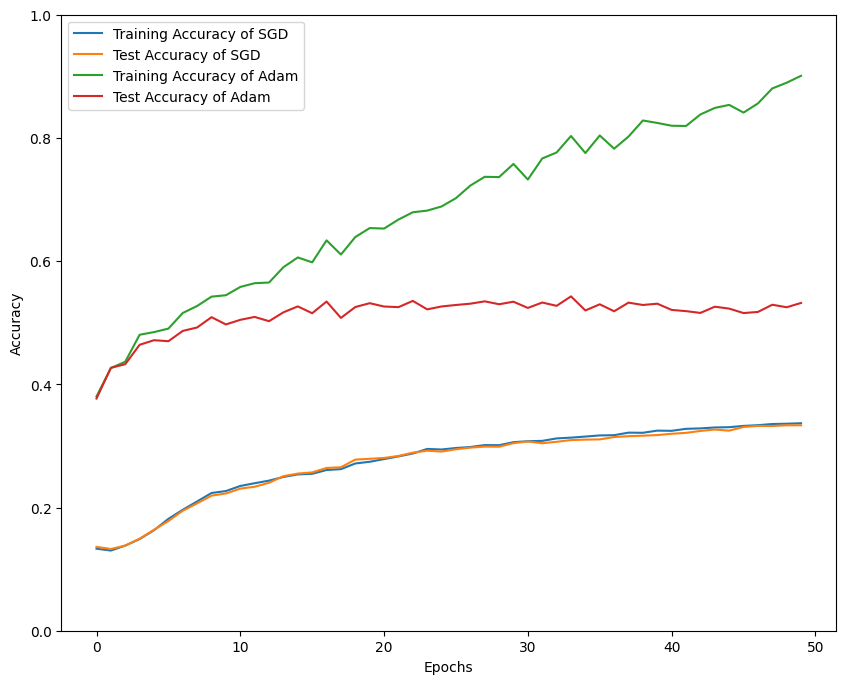

In [23]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(CIFAR_NUM_EPOCHS)
plt.plot(x_axis, cifar_accuracies[0][0], label="Training Accuracy of SGD")
plt.plot(x_axis, cifar_accuracies[0][1], label="Test Accuracy of SGD")
plt.plot(x_axis, cifar_accuracies[1][0], label="Training Accuracy of Adam")
plt.plot(x_axis, cifar_accuracies[1][1], label="Test Accuracy of Adam")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

### 결과 분석
- Adam optimizer 를 사용했을 때, 정확도가 더 높았다.
- 하지만, train 데이터셋과 test 데이터셋 간의 정확도 차이를 봤을 때, overfitting 문제가 발생했다는 것을 알 수 있다. 

## Sigmoid 를 적용한 분류 모델

In [24]:
class SimpleImageClassificationModel02(nn.Module):
    """
    활성 함수로 Sigmod 를 사용하는 분류 모델
    """

    def __init__(self, num_channels, image_width, image_height, num_output_class):
        super(SimpleImageClassificationModel02, self).__init__()

        hidden_dim = 1024
        input_dim = num_channels * image_width * image_height

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, num_output_class)

        self.activation = nn.Sigmoid()

    def forward(self, x):
        # x.shape: (batch_size, channels, width, height)
        x = torch.flatten(
            x, start_dim=1
        )  # x.shape: (batch_size, channels * width * height)
        x = self.activation(self.layer1(x))  # x.shape: (batch_size, 2048)
        x = self.activation(self.layer2(x))  # x.shape: (batch_size, 2048)
        x = self.layer3(x)  # x.shape: (batch_size, num_output_classes)
        return x

In [25]:
cifar_model_02 = SimpleImageClassificationModel02(3, 32, 32, 10).to(device)
cifar_model_02_optimizer = optim.Adam(
    cifar_model_02.parameters(), lr=CIFAR_LEARNING_RATE
)

cifar_model_02_accuracies = np.zeros((2, CIFAR_NUM_EPOCHS))

for epoch in range(CIFAR_NUM_EPOCHS):
    for data in cifar_train_loader:
        cifar_model_02_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outputs = cifar_model_02(inputs)

        loss = cifar_criterion(outputs, labels)
        loss.backward()

        cifar_model_02_optimizer.step()
    cifar_model_02_accuracies[0][epoch] = calculate_accuracy(
        device, cifar_model_02, cifar_train_loader
    )
    cifar_model_02_accuracies[1][epoch] = calculate_accuracy(
        device, cifar_model_02, cifar_test_loader
    )
    print(
        f"Epoch {epoch + 1:3d}, Training Accuracy: {cifar_model_02_accuracies[0][epoch]:.5f}"
    )

Epoch   1, Training Accuracy: 0.30694
Epoch   2, Training Accuracy: 0.38784
Epoch   3, Training Accuracy: 0.41016
Epoch   4, Training Accuracy: 0.43474
Epoch   5, Training Accuracy: 0.46462
Epoch   6, Training Accuracy: 0.46966
Epoch   7, Training Accuracy: 0.48112
Epoch   8, Training Accuracy: 0.47660
Epoch   9, Training Accuracy: 0.48866
Epoch  10, Training Accuracy: 0.51340
Epoch  11, Training Accuracy: 0.52722
Epoch  12, Training Accuracy: 0.51008
Epoch  13, Training Accuracy: 0.53160
Epoch  14, Training Accuracy: 0.52728
Epoch  15, Training Accuracy: 0.55044
Epoch  16, Training Accuracy: 0.56162
Epoch  17, Training Accuracy: 0.54162
Epoch  18, Training Accuracy: 0.54336
Epoch  19, Training Accuracy: 0.58304
Epoch  20, Training Accuracy: 0.55406
Epoch  21, Training Accuracy: 0.56264
Epoch  22, Training Accuracy: 0.57532
Epoch  23, Training Accuracy: 0.58292
Epoch  24, Training Accuracy: 0.60492
Epoch  25, Training Accuracy: 0.59740
Epoch  26, Training Accuracy: 0.60214
Epoch  27, T

### LeakyReLu 와 Sigmoid 활성 함수 별 분류 모델 정확도 그래프  

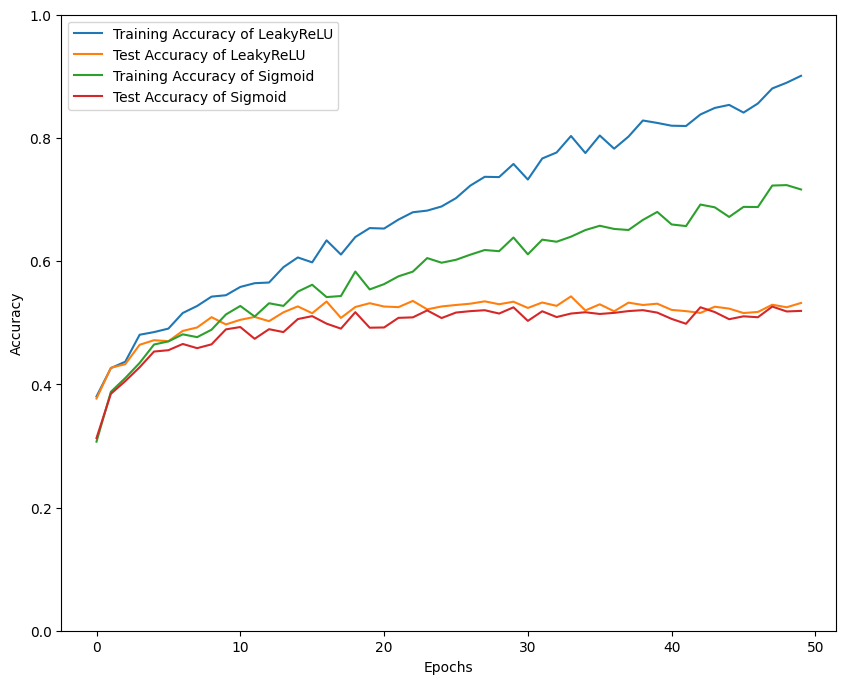

In [26]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(CIFAR_NUM_EPOCHS)
plt.plot(x_axis, cifar_accuracies[1][0], label="Training Accuracy of LeakyReLU")
plt.plot(x_axis, cifar_accuracies[1][1], label="Test Accuracy of LeakyReLU")
plt.plot(x_axis, cifar_model_02_accuracies[0], label="Training Accuracy of Sigmoid")
plt.plot(x_axis, cifar_model_02_accuracies[1], label="Test Accuracy of Sigmoid")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

### 결과 분석
- LeakyReLU 모델이 Sigmoid 모델보다 훈련 데이터에 대해 더 높은 정확도를 달성합니다.
- 그러나 테스트 정확도는 두 모델이 비슷한 수준을 보입니다.
- 즉, LeakyReLU 모델이 더 심한 과적합 현상을 보입니다.
- 두 모델 모두 overfitting 문제가 있습니다.

## Dropout 을 적용한 분류 모델

In [27]:
class SimpleImageClassificationModel03(nn.Module):
    """
    dropout 을 사용하는 분류 모델
    """

    def __init__(self, num_channels, image_width, image_height, num_output_class):
        super(SimpleImageClassificationModel03, self).__init__()

        hidden_dim = 1024
        input_dim = num_channels * image_width * image_height

        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, num_output_class)

        self.dropout = nn.Dropout()

        self.activation = nn.LeakyReLU()

    def forward(self, x):
        # x.shape: (batch_size, channels, width, height)
        x = torch.flatten(
            x, start_dim=1
        )  # x.shape: (batch_size, channels * width * height)
        x = self.activation(self.dropout(self.layer1(x)))  # x.shape: (batch_size, 2048)
        x = self.activation(self.dropout(self.layer2(x)))  # x.shape: (batch_size, 2048)
        x = self.layer3(x)  # x.shape: (batch_size, num_output_classes)
        return x

In [28]:
cifar_model_03 = SimpleImageClassificationModel03(3, 32, 32, 10).to(device)
cifar_model_03_optimizer = optim.Adam(
    cifar_model_03.parameters(), lr=CIFAR_LEARNING_RATE
)

cifar_model_03_accuracies = np.zeros((2, CIFAR_NUM_EPOCHS))

for epoch in range(CIFAR_NUM_EPOCHS):
    for data in cifar_train_loader:
        cifar_model_03_optimizer.zero_grad()

        images, labels = data
        inputs, labels = images.to(device), labels.to(device)

        outpust = cifar_model_03(inputs)

        loss = cifar_criterion(outpust, labels)
        loss.backward()

        cifar_model_03_optimizer.step()

    cifar_model_03_accuracies[0][epoch] = calculate_accuracy(
        device, cifar_model_03, cifar_train_loader
    )
    cifar_model_03_accuracies[1][epoch] = calculate_accuracy(
        device, cifar_model_03, cifar_test_loader
    )
    print(
        f"Epoch {epoch + 1:3d}, Training Accuracy: {cifar_model_03_accuracies[0][epoch]:.5f}"
    )

Epoch   1, Training Accuracy: 0.35946
Epoch   2, Training Accuracy: 0.37536
Epoch   3, Training Accuracy: 0.39214
Epoch   4, Training Accuracy: 0.39070
Epoch   5, Training Accuracy: 0.42362
Epoch   6, Training Accuracy: 0.42958
Epoch   7, Training Accuracy: 0.43240
Epoch   8, Training Accuracy: 0.42896
Epoch   9, Training Accuracy: 0.43406
Epoch  10, Training Accuracy: 0.43348
Epoch  11, Training Accuracy: 0.44480
Epoch  12, Training Accuracy: 0.44578
Epoch  13, Training Accuracy: 0.46188
Epoch  14, Training Accuracy: 0.44206
Epoch  15, Training Accuracy: 0.46074
Epoch  16, Training Accuracy: 0.45566
Epoch  17, Training Accuracy: 0.46882
Epoch  18, Training Accuracy: 0.46554
Epoch  19, Training Accuracy: 0.43642
Epoch  20, Training Accuracy: 0.47696
Epoch  21, Training Accuracy: 0.46234
Epoch  22, Training Accuracy: 0.47134
Epoch  23, Training Accuracy: 0.47410
Epoch  24, Training Accuracy: 0.48202
Epoch  25, Training Accuracy: 0.47196
Epoch  26, Training Accuracy: 0.48682
Epoch  27, T

### Dropout 적용 유무 별 분류 모델 정확도 그래프 

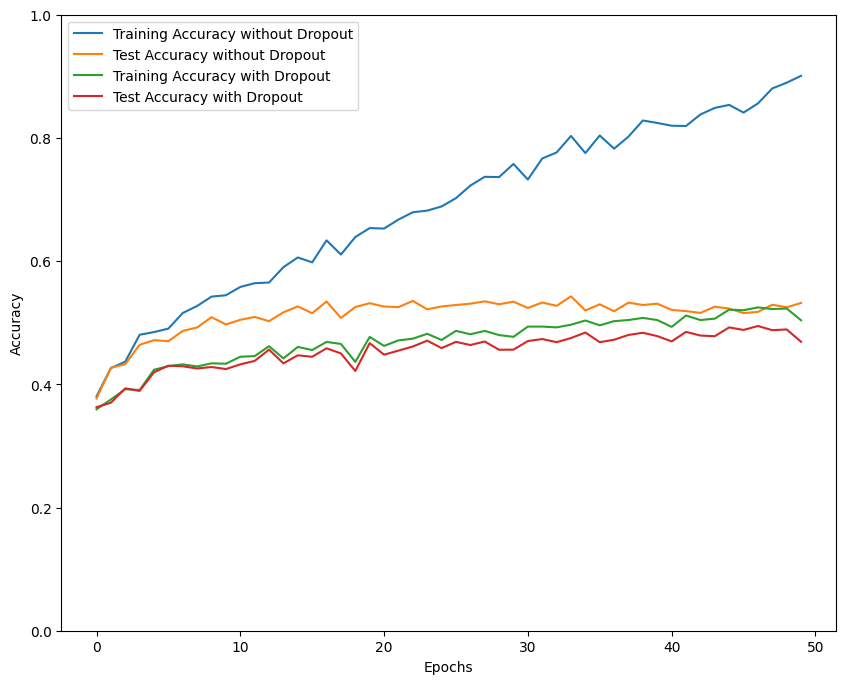

In [29]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(CIFAR_NUM_EPOCHS)
plt.plot(x_axis, cifar_accuracies[1][0], label="Training Accuracy without Dropout")
plt.plot(x_axis, cifar_accuracies[1][1], label="Test Accuracy without Dropout")
plt.plot(x_axis, cifar_model_03_accuracies[0], label="Training Accuracy with Dropout")
plt.plot(x_axis, cifar_model_03_accuracies[1], label="Test Accuracy with Dropout")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

### 결과 분석
- Dropout을 적용하지 않은 모델이 훈련 데이터에 대해 훨씬 높은 정확도를 달성합니다.
- 그러나 테스트 정확도는 Dropout을 적용한 모델이 조금 더 높은 수준을 보입니다.
- Dropout은 모델의 과적합을 효과적으로 줄이고 일반화 능력을 향상시켰습니다.
- 훈련 정확도는 낮아졌지만, 테스트 정확도는 소폭 향상되었습니다.